In [17]:
import pandas as pd
import numpy as np

def prepare_connolly_dataset(filepath='irish_rail_historical_data.csv', max_prev_stations=3, output_file='dublin_connolly_clean_with_history.csv'):
    # Read the full dataset
    df = pd.read_csv(filepath)

    # Helper function to combine date and time into a datetime
    def combine_date_time(row, time_col):
        date_str = str(row['TrainDate']).strip()
        time_str = str(row[time_col]).strip() if pd.notnull(row[time_col]) else ''
        return pd.to_datetime(f"{date_str} {time_str}", errors='coerce')

    # Apply datetime conversion
    for col in ['ScheduledArrival', 'ActualArrival', 'ScheduledDeparture', 'ActualDeparture']:
        df[f'{col}DT'] = df.apply(lambda row: combine_date_time(row, col), axis=1)

    # Calculate delay
    def compute_delay(row):
        if row['LocationType'] == 'D':  # Destination station
            if pd.notnull(row['ScheduledArrivalDT']) and pd.notnull(row['ActualArrivalDT']):
                return (row['ActualArrivalDT'] - row['ScheduledArrivalDT']).total_seconds() / 60
        else:  # Other stations, use departure
            if pd.notnull(row['ScheduledDepartureDT']) and pd.notnull(row['ActualDepartureDT']):
                return (row['ActualDepartureDT'] - row['ScheduledDepartureDT']).total_seconds() / 60
        return None

    df['delay_minutes'] = df.apply(compute_delay, axis=1)

    # Sort for historical lookup
    df['SortTime'] = df.apply(
        lambda row: row['ActualDepartureDT'] if pd.notnull(row['ActualDepartureDT']) else row['ActualArrivalDT'], 
        axis=1
    )
    df = df.sort_values(['TrainCode', 'TrainDate', 'SortTime'])

    # Function to retrieve previous stations
    def get_previous_stations(df, train_code, train_date, current_station, max_stations):
        train_stations = df[(df['TrainCode'] == train_code) & 
                            (df['TrainDate'] == train_date)]
        try:
            current_idx = train_stations[train_stations['LocationFullName'] == current_station].index[0]
        except IndexError:
            return [], []  # Station not found
        
        prev_stations = train_stations[train_stations.index < current_idx]
        
        if len(prev_stations) == 0:
            return [], []
        
        prev_stations = prev_stations.iloc[-max_stations:] if len(prev_stations) >= max_stations else prev_stations
        
        station_names = prev_stations['LocationFullName'].tolist()
        station_delays = prev_stations['delay_minutes'].tolist()
        
        return station_names, station_delays

    # Filter for Dublin Connolly
    connolly_df = df[df['LocationFullName'] == 'Dublin Connolly'].copy()
    connolly_df.dropna(subset=['ActualArrival', 'ScheduledArrival', 'ScheduledDeparture', 'ActualDeparture'], inplace=True)

    # Initialize columns dynamically
    for i in range(1, max_prev_stations + 1):
        connolly_df[f'prev_station_{i}'] = None
        connolly_df[f'prev_delay_{i}'] = 0.0

    # Populate previous station data
    for idx, row in connolly_df.iterrows():
        prev_stations, prev_delays = get_previous_stations(
            df, row['TrainCode'], row['TrainDate'], 'Dublin Connolly', max_prev_stations
        )
        
        stations_padded = prev_stations + [None] * (max_prev_stations - len(prev_stations))
        delays_padded = prev_delays + [0.0] * (max_prev_stations - len(prev_delays))
        
        stations_padded = stations_padded[-max_prev_stations:]
        delays_padded = delays_padded[-max_prev_stations:]
        
        # Assign in reverse order (most recent first)
        for i in range(max_prev_stations):
            connolly_df.at[idx, f'prev_station_{i+1}'] = stations_padded[-(i+1)]
            connolly_df.at[idx, f'prev_delay_{i+1}'] = delays_padded[-(i+1)]

    # Drop rows where delay couldn't be calculated
    connolly_df = connolly_df.dropna(subset=['delay_minutes'])

    # Feature engineering
    connolly_df['scheduled_hour'] = connolly_df.apply(
        lambda row: row['ScheduledDepartureDT'].hour if row['LocationType'] != 'D' else row['ScheduledArrivalDT'].hour, 
        axis=1
    )
    connolly_df['day_of_week'] = pd.to_datetime(connolly_df['TrainDate']).dt.dayofweek

    # Build final feature list dynamically
    selected_columns = [
        'TrainOrigin', 'TrainDestination', 
        'scheduled_hour', 'day_of_week'
    ]
    for i in range(1, max_prev_stations + 1):
        selected_columns.append(f'prev_station_{i}')
        selected_columns.append(f'prev_delay_{i}')
    selected_columns.append('delay_minutes')

    df_model = connolly_df[selected_columns]

    # Convert station names to categorical
    for i in range(1, max_prev_stations + 1):
        df_model[f'prev_station_{i}'] = df_model[f'prev_station_{i}'].astype('category')

    # Save the final dataset
    df_model.to_csv(output_file, index=False)

    print(f"✅ Cleaned dataset saved to {output_file} with {len(df_model)} rows.")
    print(f"Number of unique trains: {connolly_df['TrainCode'].nunique()}")

# Example usage:
prepare_connolly_dataset(max_prev_stations=10)


✅ Cleaned dataset saved to dublin_connolly_clean_with_history.csv with 14883 rows.
Number of unique trains: 19


/tmp/ipykernel_11614/1571229935.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[f'prev_station_{i}'] = df_model[f'prev_station_{i}'].astype('category')
/tmp/ipykernel_11614/1571229935.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[f'prev_station_{i}'] = df_model[f'prev_station_{i}'].astype('category')
/tmp/ipykernel_11614/1571229935.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Load cleaned data
df = pd.read_csv('dublin_connolly_clean_with_history.csv')

# Encode categorical features
categorical_cols = ['TrainOrigin', 'TrainDestination', 'prev_station_1', 'prev_station_2', 'prev_station_3']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(df[categorical_cols])

encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))
df_final = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)

# Define features and target
X = df_final.drop(columns=['delay_minutes'])
y = df_final['delay_minutes']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluation
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    print(f"📊 {model_name} Results:")
    print(f"   MAE : {mae:.2f} minutes")
    print(f"   RMSE: {rmse:.2f} minutes\n")

evaluate(y_test, y_pred_lr, "Linear Regression")
evaluate(y_test, y_pred_rf, "Random Forest Regressor")


ValueError: could not convert string to float: 'Raheny'

In [14]:
df.head()

,TrainOrigin,TrainDestination,scheduled_hour,day_of_week,prev_station_1,prev_delay_1,prev_station_2,prev_delay_2,prev_station_3,prev_delay_3,delay_minutes
0,Dublin Connolly,Rosslare Europort,13,1,NaN,0.0,NaN,0.0,NaN,0.0,3.1
1,Dublin Connolly,Rosslare Europort,13,5,NaN,0.0,NaN,0.0,NaN,0.0,0.5
2,Dublin Connolly,Rosslare Europort,13,2,NaN,0.0,NaN,0.0,NaN,0.0,3.2
3,Dublin Connolly,Rosslare Europort,13,6,NaN,0.0,NaN,0.0,NaN,0.0,0.7
4,Dublin Connolly,Rosslare Europort,13,3,NaN,0.0,NaN,0.0,NaN,0.0,5.7


In [15]:
from sklearn.model_selection import cross_val_score
import numpy as np

scores = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-validated MAE: {-np.mean(scores):.2f} ± {np.std(scores):.2f}")

Cross-validated MAE: 1.38 ± 0.64


/tmp/ipykernel_11614/692666539.py:18: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/home/stang/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


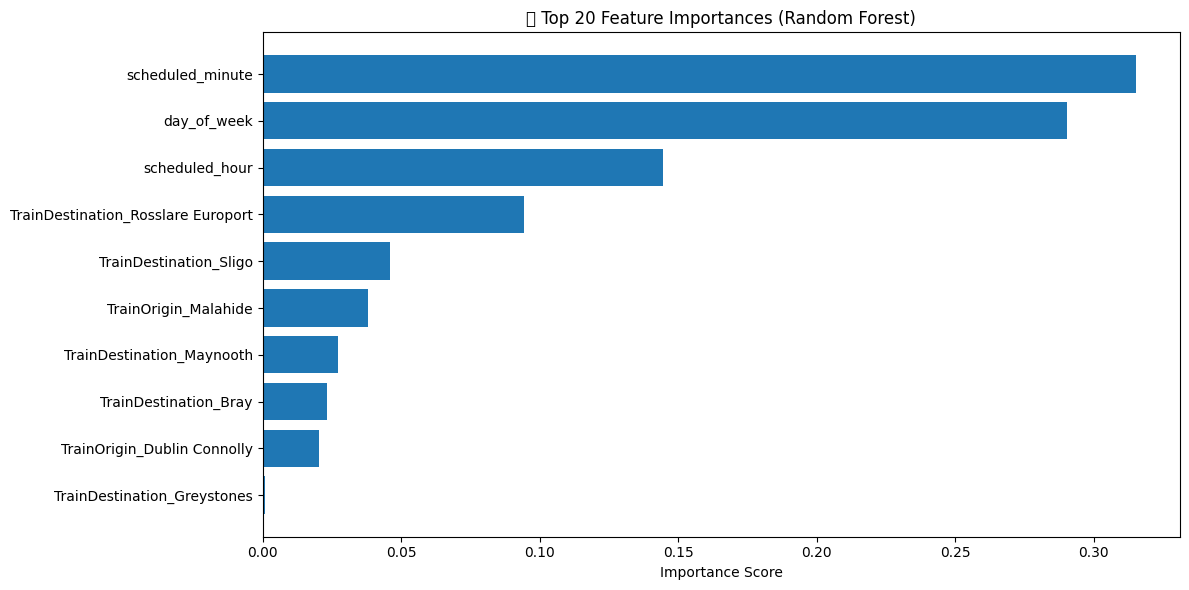

In [10]:
import matplotlib.pyplot as plt

# Get feature importances from the Random Forest model
importances = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame and sort
fi_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 6))
plt.barh(fi_df['feature'][:20][::-1], fi_df['importance'][:20][::-1])
plt.title('🔍 Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

/tmp/ipykernel_11614/2609606278.py:17: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()


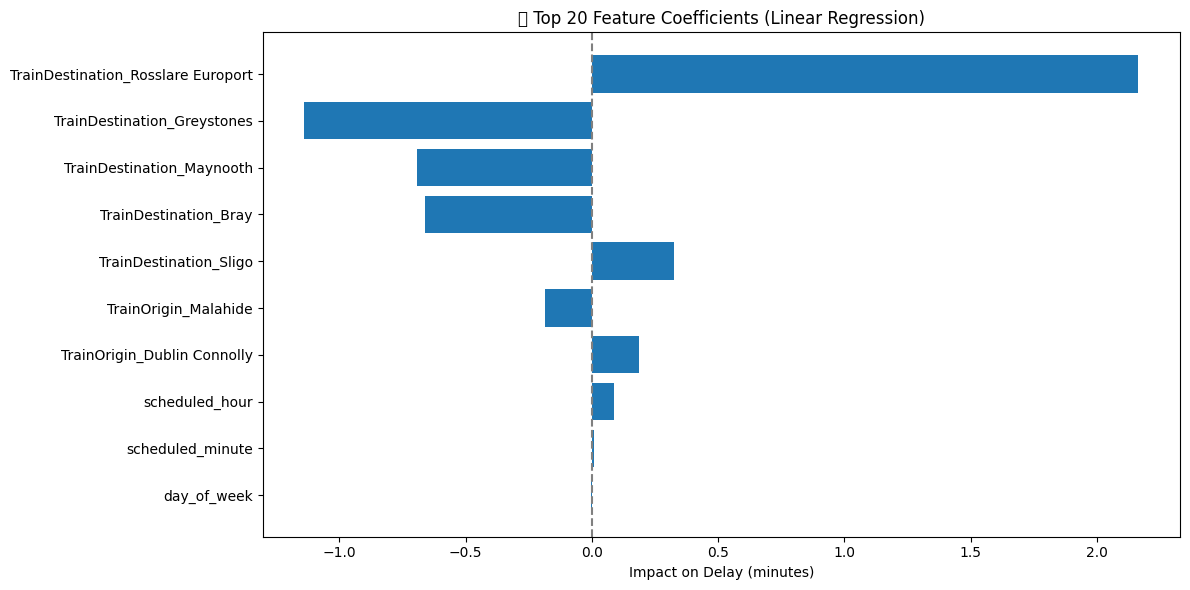

In [11]:
# Extract coefficients
coef = lr.coef_
features = X.columns

# Create DataFrame for coefficients
coef_df = pd.DataFrame({
    'feature': features,
    'coefficient': coef
}).sort_values(by='coefficient', key=abs, ascending=False)

# Plot top 20 by absolute value
plt.figure(figsize=(12, 6))
plt.barh(coef_df['feature'][:20][::-1], coef_df['coefficient'][:20][::-1])
plt.axvline(0, color='gray', linestyle='--')
plt.title('🔍 Top 20 Feature Coefficients (Linear Regression)')
plt.xlabel('Impact on Delay (minutes)')
plt.tight_layout()
plt.show()
